In [1]:
import os
# HOME = os.getcwd()
HOME = '/workspace/football'
print(HOME)

/workspace/football


In [2]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

# %matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()


In [3]:
SOURCE_VIDEO_PATH = f"{HOME}/20_sec_test.mp4"
WEIGHTS_PATH = f"{HOME}/best.pt"

In [4]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device=0)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-5 Python-3.10.11 torch-2.0.1+cu117 CUDA:0 (NVIDIA A40, 45449MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [5]:
frame_num = 4
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))
for i, frame in enumerate(frame_iterator):
    if i>frame_num:
        break
frame_16 = frame

frame_num = 600
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))
for i, frame in enumerate(frame_iterator):
    if i>frame_num:
        break
frame_600 = frame


In [6]:
results_16 = model(frame_16, size=1280)
results_600 = model(frame_600, size=1280)


In [7]:
querry = {}
for i, bbox in enumerate(results_16.pred[0]):
    left, top, right, bottom = bbox[:4].round().int()
    querry[i] = [bbox.round().int().cpu().numpy(), frame_16[top:bottom,left:right,::-1]]

gallery = {}
for i, bbox in enumerate(results_600.pred[0]):
    left, top, right, bottom = bbox[:4].round().int()
    gallery[i] = [bbox.round().int().cpu().numpy(), frame_600[top:bottom,left:right,::-1]]

In [8]:
def draw_bbox_ids(players, frame, save_path):
    frame_tmp = frame.copy()
    player_id = 0
    for i in range(len(players)):
        # print(players[i][0])
        x1, y1, x2, y2, conf, cls = players[i][0]
        if conf > 0.5:  # Adjust the confidence threshold as needed
            cv2.rectangle(frame_tmp, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            cv2.putText(frame_tmp, f"ID: {player_id}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            player_id += 1
    plt.imsave(save_path, frame_tmp[...,::-1])
        # 'demo_frames/Frame_16_querry.png'

In [10]:
plt.imsave('demo_frames/18.png', querry[18][1])

In [9]:
save_path = 'demo_frames/Frame_16_querry.png'
draw_bbox_ids(querry, frame_16, save_path)

In [10]:
save_path = 'demo_frames/Frame_600_gallery.png'
draw_bbox_ids(gallery, frame_600, save_path)

In [11]:
from torchreid.utils import FeatureExtractor
import torch
from torch.nn import functional as F
from torchreid import metrics

In [12]:
extractor = FeatureExtractor(
    model_name='vit_b_16',
    # model_path='/workspace/football/sportsreid/log/model.vit_b.pth.tar-10',
    model_path='/workspace/football/sportsreid/log/model/model.pth.tar-50',
    device='cuda',
    image_size=(224, 224)
)

Model: vit_b_16
- params: 57,692,928
- flops: 11,279,979,008
Successfully loaded pretrained weights from "/workspace/football/sportsreid/log/model/model.pth.tar-50"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [15]:
extractor_resnet = FeatureExtractor(
    model_name='resnet50_fc512',
    model_path='/workspace/football/sn-reid/log/model/model_resnet50-fc512.pth.tar-50',
    device='cuda',
    # image_size=(224, 224)
)

Model: resnet50_fc512
- params: 24,558,144
- flops: 4,054,319,616
Successfully loaded pretrained weights from "/workspace/football/sn-reid/log/model/model_resnet50-fc512.pth.tar-50"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [24]:
# gallery_features = extractor_resnet([i[1] for i in gallery.values()])
# querry_features = extractor_resnet([i[1] for i in querry.values()])
gallery_features = extractor([i[1] for i in gallery.values()])
querry_features = extractor([i[1] for i in querry.values()])

In [163]:
# plt.imsave('demo_frames/18.png', [i[1] for i in gallery.values()][5])

In [164]:
# gallery_features = F.normalize(gallery_features, p=2, dim=1)
# querry_features = F.normalize(querry_features, p=2, dim=1)

In [25]:
distmat = metrics.compute_distance_matrix(querry_features.cpu(), gallery_features.cpu(), 'euclidean')
distmat = distmat.numpy()

In [166]:
distmat.shape

(22, 25)

In [23]:
distmat.argsort(axis=1)[:,:3]

array([[ 1,  7,  3],
       [11,  5,  4],
       [16,  5, 13],
       [11, 13, 16],
       [18, 10,  9],
       [14,  9, 18],
       [ 7,  3, 18],
       [10, 18,  7],
       [10, 18, 14],
       [19, 15,  4],
       [15,  2,  4],
       [20,  6,  9],
       [20,  6, 14],
       [13,  5,  2],
       [13,  5, 11],
       [ 2,  5, 13],
       [ 1,  7, 20],
       [ 7,  1, 17],
       [ 0, 16, 13],
       [ 5, 11, 16],
       [21, 23, 12],
       [23, 12, 21]])

In [16]:
querry2gallery = distmat.argmin(axis=1)
querry2gallery

array([ 1, 11, 16, 11, 18, 14,  7, 10, 10, 19, 15, 20, 20, 13, 13,  2,  1,  7,  0,  5, 21, 23])

In [19]:
np.isclose(querry2gallery, querry2gallery_gt[:,1])

array([ True, False,  True,  True,  True,  True, False, False,  True,  True,  True,  True, False, False,  True, False, False,  True,  True,  True,  True,  True])

In [18]:
np.mean((querry2gallery == querry2gallery_gt[:,1]))

0.6818181818181818

In [195]:
np.mean(np.isclose(querry2gallery, querry2gallery_gt[:,1]))

0.45454545454545453

In [73]:
querry2gallery_gt[:,1]

array([ 1,  4, 16, 11, 18, 14,  3, 17, 10, 19, 15, 20,  6,  2, 13,  8,  9,  7,  0,  5, 21, 23])

In [15]:
# querry -> gallery
querry2gallery_gt = np.array([[1, 4],
                    [0, 1],
                    [8, 10],
                    [7, 17],
                    [3, 11],
                    [9, 19],
                    [17, 7],
                    [18, 0],
                    [5, 14],
                    [4, 18],
                    [21, 23],
                    [12, 6],
                    [6, 3],
                    [13, 2],
                    [20, 21],
                    [19, 5],
                    [11, 20],
                    [15, 8],
                    [14, 13],
                    [2, 16],
                    [16, 9],
                    [10, 15]])
querry2gallery_gt = querry2gallery_gt[querry2gallery_gt[:, 0].argsort()]
querry2gallery_gt

array([[ 0,  1],
       [ 1,  4],
       [ 2, 16],
       [ 3, 11],
       [ 4, 18],
       [ 5, 14],
       [ 6,  3],
       [ 7, 17],
       [ 8, 10],
       [ 9, 19],
       [10, 15],
       [11, 20],
       [12,  6],
       [13,  2],
       [14, 13],
       [15,  8],
       [16,  9],
       [17,  7],
       [18,  0],
       [19,  5],
       [20, 21],
       [21, 23]])

In [22]:
querry2gallery

array([ 1,  5, 16, 13,  9, 20,  9, 10, 10, 19, 15, 20, 20, 13, 13,  8, 20, 20,  0, 13, 23, 23])

In [21]:
querry2gallery_gt_dict = {}
for i in range(len(querry2gallery_gt)):
    querry2gallery_gt_dict[querry2gallery_gt[i][0]] = querry2gallery_gt[i][1]

In [22]:
distmat.argsort(axis=1)[:,:3][q]

NameError: name 'q' is not defined

In [32]:
g

23

In [30]:
g in distmat.argsort(axis=1)[:,:3][q][1:]

False

In [35]:
frame_gallery = cv2.imread('demo_frames/Frame_600_gallery.png')
frame_tmp = frame_gallery.copy()
# player_id = 0
save_path = 'demo_frames/Frame_600_result)_2.png'
for q, g in querry2gallery_gt_dict.items():
    # print(players[i][0])
    x1, y1, x2, y2, conf, cls = gallery[g][0]
    if g == distmat.argsort(axis=1)[:,:3][q][0]:
        cv2.rectangle(frame_tmp, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    if g in distmat.argsort(axis=1)[:,:3][q][1:]:
        cv2.rectangle(frame_tmp, (int(x1), int(y1)), (int(x2), int(y2)), (0, 127, 255), 2)
        
    cv2.putText(frame_tmp, f"Prev: {q}", (int(x1)-20, int(y1) - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(frame_tmp, f"Pred@3: {distmat.argsort(axis=1)[:,:3][q]}", (int(x1)-50, int(y1) - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 70, 100), 2)
plt.imsave(save_path, frame_tmp[...,::-1])

In [37]:
np.median(distmat[0])

1.492274

In [30]:
distmat[0]

array([     2.3432,     0.45953,      1.9652,      1.1377,      2.1652,      1.9744,      1.2519,      1.2185,      2.0493,      1.3623,      1.0551,      1.9939,      2.0379,       1.851,     0.82924,      2.0568,      2.1401,      1.1393,      1.3565,      2.1091,      1.5307,      1.8385,      1.6384,      2.0893,
            1.5316], dtype=float32)

In [31]:
distmat[0].min()

0.45952713

In [41]:
np.median(distmat[0])

1.8384562

In [19]:
np.where(distmat == distmat.min())

(array([0]), array([1]))

In [23]:
import torchvision.transforms as T

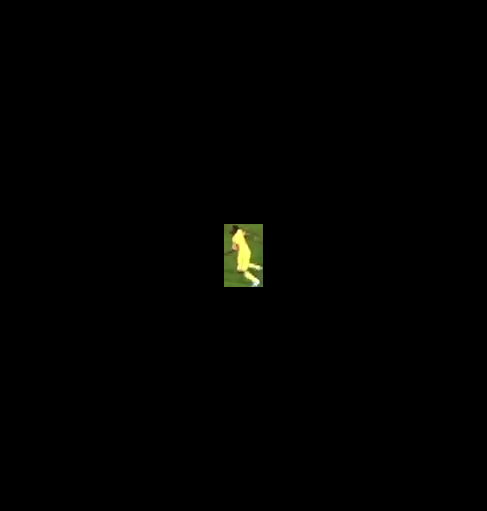

In [31]:
transforms = [T.ToPILImage(),T.Pad((224, 224))]
preprocess = T.Compose(transforms)
p_img = preprocess(img)
p_img

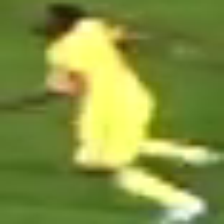

In [34]:
transforms = [T.ToPILImage(),T.Resize((224, 224))]
preprocess = T.Compose(transforms)
p_img = preprocess(img)
p_img

In [33]:
p_img.size

(487, 511)

In [27]:
for i, img in enumerate(gallery.values()):
    print(f'{i}:')
    if i > 3:
        break
    plt.imshow(img)
    plt.show()

0:
1:
2:
3:
4:


In [150]:
plt.imshow(gallery[0])

KeyError: 0

In [ ]:
image_points = frame.copy()
# image_points = cv2.resize(image_points,(256,256))
for i, coord in enumerate(result[0]['kps']):
                # print('ha')
center_cyrcle=(int(coord[0]), int(coord[1]))
center_cyrcle = np.clip(center_cyrcle,1,511)
image_points = cv2.circle(image_points, center_cyrcle, radius=3, color=(0, 255, 0), thickness=-1)